# Probabilistic Attribution Models
Probabilistic Attribution is a process that relies on statistical modeling and machine learning techniques to derive probability of conversion across all marketing touchpoints. These can then be used to weigh the value of each touchpoint preceding the conversion.

## Import Dependencies and Load Data

In [2]:
import itertools
from collections import Counter, defaultdict
from itertools import permutations, combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from gekko import GEKKO
from pandas.plotting import scatter_matrix
from pandas_profiling import ProfileReport
from PIL import Image

%matplotlib inline
pd.options.mode.chained_assignment = None
sns.set_palette('summer')

In [3]:
df = pd.read_csv('data/attribution_data.csv')
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


## Markov Attribution Model
The Markov Attribution model will represent buyer journeys as a directed graph, with the nodes being the touchpoints or "states", and the graph's connecting edges being the observed transitions between those states. 
> The **key ingredient** to the model is the transition probabilities (likelihood of moving between states). The number of times buyers have transitioned between two states is converted into a probability, and the complete graph can be used to measure the importance of each state and most likely paths to success.

This model should be used when the number of channels for a particular campaign is between 10 and 15.

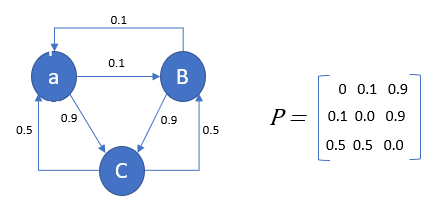

In [5]:
im = Image.open(requests.get('https://miro.medium.com/max/437/1*SUUir-VGHy2OFqbpKxwuJA.png', stream=True).raw)
im

- Probability distribution of going from one state to another state
- Defined by these properties: the **state space** (states that could potentially exist, which are the channels), **transition probabilities** (probability of moving from one state to another state)

### Removal Effect
> A campaign's effectiveness is determined by removing it from the graph and simulating buyer journeys to meausre the change in success rate without it in place.

$removal effect(i)=1 - \frac{probability without i}{probability with i}$

If we want to find a channel's contribution, we can do so by removing it, and seeing how many conversions take place without that channel existing.

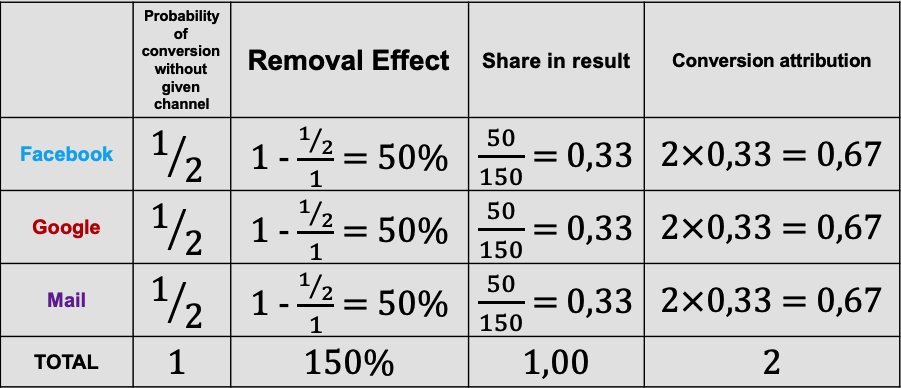

In [72]:
im = Image.open(requests.get('https://adequate.digital/wp-content/uploads/2019/07/share-in-result-markov-chain.png', stream=True).raw)
im

In [70]:
def transition_states(list_of_paths):
    """
    Function to calculate all the states
    """
    unique_channels = set(x for ele in list_of_paths for x in ele)
    
    # Acquire states
    transition_state = {x + '>' + y: 0 for x in unique_channels
                        for y in unique_channels}
    
    # Get frequencies of all possible combinations
    for state in unique_channels:
        if state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if state in user_path:
                    idx = [i for i, s in enumerate(user_path) if state in s]
                    for col in idx:
                        transition_state[user_path[col] + '>' + 
                                         user_path[col + 1]] += 1
    
    return transition_state


def transition_prob(trans_dict, list_of_paths):
    """
    Function to assign probabilities to each combination of length 2 of paths
    """
    unique_channels = set(x for ele in list_of_paths for x in ele)
    trans_prob = defaultdict(dict)
    for state in unique_channels:
        if state not in ['Conversion', 'Null']:
            # Get amount of paths that start with state
            counter = 0
            # Get indices in transition dictionary where state
            # starts current key
            idx = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            
            # Calculate transition probabilities for each unique 
            # combination of paths
            for col in idx:
                # list(trans_dict)[col] gets the current combination
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in idx:
                if trans_dict[list(trans_dict)[col]] > 0:
                    # Calculate prob of current state
                    state_prob = float((
                        trans_dict[list(trans_dict)[col]]
                    )) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob
    
    return trans_prob


def transition_matrix(list_of_paths, transition_probabilities):
    """
    Function to create a transition matrix using the probabilities of
    each paths of length 2
    """
    trans_matrix = pd.DataFrame()
    unique_channels = set(x for ele in list_of_paths for x in ele)
    
    for channel in unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in [
            'Conversion', 'Null'] else 0.00
        
    for k, v in transition_probabilities.items():
        origin, dest = k.split('>')
        trans_matrix.at[origin, dest] = v
    
    return trans_matrix


def removal_effects(df, conversion_rate):
    """
    Calculate the effect of a channel if it was removed 
    (input df is transition matrix)
    """
    removal_effects = {}
    channels = [channel for channel in df.columns if channel not in [
        'Start', 'Null', 'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for col in removal_df.columns:
            # Get row sum of each channel that remains
            row_sum = np.sum(list(removal_df.loc[col]))
            null_pct = 1.00 - row_sum
            if null_pct != 0:
                # Values in Null column will change
                # i.e., probabilities of ending in Null will change
                removal_df.loc[col]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0
        
        # Only get paths ending in Null and Conversion, but not starting at
        removal_to_conv = removal_df[['Null', 'Conversion']].drop(
            ['Null', 'Conversion'], 0)
        
        # Only get paths that don't have Null or Conversion
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], 1).drop(['Null', 'Conversion'], 0)

        # Calculations
        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(
                removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index
                                  )[[1]].loc['Start'].values[0]
        
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects[channel] = removal_effect
    
    return removal_effects


def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))
    return {k: (v / re_sum) * total_conversions for k, v 
            in removal_effects.items()}


def markov_model(df, conv_col, channel_col, user_id):
    df = df.sort_values(user_id)
    
    # Increase number of visits for user each time it occurs in record
    df['visit_order'] = df.groupby(user_id).cumcount() + 1
    
    # Convert user visit records to list of states per user
    df_paths = df.groupby(user_id)[channel_col].aggregate(
        lambda x: x.unique().tolist()).reset_index()
    
    # Tell whether user converted
    df_last_interaction = df.drop_duplicates(
        user_id, keep='last')[[user_id, conv_col]]
    
    # Append to df_paths
    df_paths = pd.merge(
        df_paths, df_last_interaction, how='left', on=user_id)
    
    # If customer did not convert, add Null to end of path, 
    # Conversion otherwise
    df_paths['start'] = [['Start'] for i in range(
        len(df_paths[conv_col]))]
    df_paths['buff'] = [['Conversion'] for i in range(
        len(df_paths[conv_col]))]
    df_paths['null'] = [['Null'] for i in range(
        len(df_paths[conv_col]))]
    df_paths['path'] = np.where(
        df_paths[conv_col] == 0, 
        df_paths['start'] + df_paths[channel_col] + df_paths['null'], 
        df_paths['start'] + df_paths[channel_col] + df_paths['buff'])
    df_paths = df_paths[[user_id, 'path']]
    
    list_of_paths = df_paths['path']
    total_conversions = sum(
        x.count('Conversion') for x in df_paths['path'].tolist()
    )
    
    # Get base rate at which users in dataset converted
    base_conversion_rate = total_conversions / len(list_of_paths)
    
    # Get frequency of each possible length 2 combination of paths
    trans_states = transition_states(list_of_paths)

    trans_prob = transition_prob(trans_states, list_of_paths)
    trans_matrix = transition_matrix(list_of_paths, trans_prob)
    removal_effects_dict = removal_effects(trans_matrix, 
                                           base_conversion_rate)
    attributions = markov_chain_allocations(removal_effects_dict, 
                                            total_conversions)
    
    res_markov = pd.DataFrame(attributions.values(), index=attributions.keys())
    res_markov.columns = ['weight']
    _sum = res_markov['weight'].sum()
    res_markov['Weight (%)'] = res_markov.apply(
        lambda x: round((x['weight'] / _sum) * 100, 2), 1)
    res_markov.drop(['weight'], 1, inplace=True)
    res_markov = res_markov.sort_index()
    return res_markov.sort_values('Weight (%)', ascending=False)


markov = markov_model(df, 'conversion', 'channel', 'cookie')
markov

,Weight (%)
Facebook,28.55
Paid Search,27.46
Instagram,15.76
Online Video,15.38
Online Display,12.85
